# Lab 10: Parts of Speech Tagging

In this lab we will start implementation of POS tagging using LSTM

Sequence tagging is a task of assigning some tag, or label, to each element in the sequence. It can be a name entitiy tag or a pos-tag. You can already see that CNNs are not really applicable for this task since they transform the whole input into some feature vector. 

To assign a label for each element in a sequence, we need to apply some transformation for each element as well. However, the _context_ can be very important for choosing the correct tag. For example, a noun is usually preceded by an article. We can achieve this with [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network).

To have a more illustative example, let's look at the picture below:


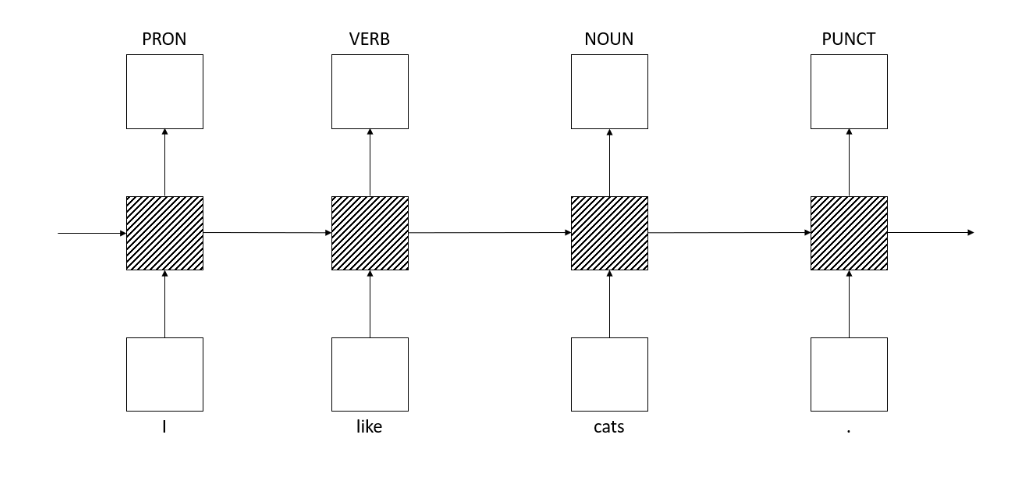


Here, a square with the diagonal stripes is an **RNN unit**. You may notice, that it has one input and two outputs. 

To better understand what these outputs mean and how we can use them, let's look inside one of the RNN units, or **RNN cells**.

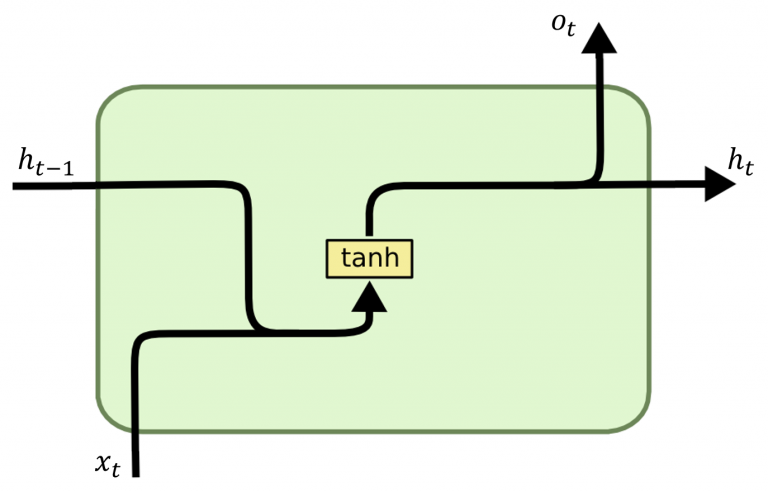

This simple cell consists of only one TanH activation function (it can be replaced with ReLU). As an input, it takes the **hidden state** from the previous cell and the input itself which can be a word embedding, for example. In this case, the output hidden state is the same as the output of the cell. Passing this hidden state as an input to the next cell will transfer some information from the context.

Now, the cell above is very simple. There are more efficient variations like [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) or [GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit). 

Let's look inside an LSTM cell.



<a title="Guillaume Chevalier / CC BY (https://creativecommons.org/licenses/by/4.0)" href="https://commons.wikimedia.org/wiki/File:The_LSTM_cell.png"><img width="512" alt="The LSTM cell" src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/The_LSTM_cell.png/512px-The_LSTM_cell.png"></a>

We can see, that it has more inputs and outputs, as well as more layers inside the cell, but the main concept stays the same. This time $h_t$ is a hidden state at the timestamp $t$, and $c_t$ is a **cell state** at the timestep $t$. 

As we are going to impliment an LSTM model in this Lab, we need to understand how to route the inputs and outputs correctly. The inside magic of the network will be done for us by PyTorch. Our job is just to plug in the wires into the correct slots.

You can also read more about LSTMs [in this blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

In [1]:
!wget https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/train_pos.txt

--2023-04-08 19:12:18--  https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/train_pos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1855828 (1,8M) [text/plain]
Saving to: ‘train_pos.txt.1’

train_pos.txt.1     100%[===================>]   1,77M  2,94MB/s    in 0,6s    

2023-04-08 19:12:19 (2,94 MB/s) - ‘train_pos.txt.1’ saved [1855828/1855828]



In [2]:
!head -n 10 train_pos.txt

Confidence NN
in IN
the DT
pound NN
is VBZ
widely RB
expected VBN
to TO
take VB
another DT


### Read the dataset (you have seen it in lab 4)

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class PoSDataset(Dataset):
    def __init__(self, sentences, tags):
        self.sentences = sentences
        self.tags = tags

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        return self.sentences[index], self.tags[index]


def read_data(file_path):
    with open(file_path, "r") as f:
        content = f.read()
    sentences_raw = content.split(" \n")[:-1]
    sentences, tags = [], []
    for sent in sentences_raw:
        words, pos_tags = [], []
        for word_tag in sent.split("\n"):
            if word_tag:
                word, tag = word_tag.split(" ")
                words.append(word)
                pos_tags.append(tag)
        sentences.append(words)
        tags.append(pos_tags)
    return sentences, tags

In [4]:
file_path = "train_pos.txt"
sentences, tags = read_data(file_path)

In [5]:
def create_vocab(sentences, tags):
    vocab = {"<PAD>": 0, "<UNK>": 1}
    tags_vocab = {"<PAD>": 0}

    for sent, pos_tags in zip(sentences, tags):
        for word, tag in zip(sent, pos_tags):
            if word not in vocab:
                vocab[word] = len(vocab)
            if tag not in tags_vocab:
                tags_vocab[tag] = len(tags_vocab)

    return vocab, tags_vocab

In [6]:
vocab, tags_vocab = create_vocab(sentences, tags)


In [7]:
def tokenize_and_pad(sentences, tags, vocab, tags_vocab, seq_len):
    tokenized_sentences = []
    tokenized_tags = []

    for sent, pos_tags in zip(sentences, tags):
        tokenized_sent = [vocab.get(word, vocab["<UNK>"]) for word in sent[:seq_len]]
        tokenized_tag = [tags_vocab[tag] for tag in pos_tags[:seq_len]]

        # Padding
        tokenized_sent += [vocab["<PAD>"]] * (seq_len - len(tokenized_sent))
        tokenized_tag += [tags_vocab["<PAD>"]] * (seq_len - len(tokenized_tag))

        tokenized_sentences.append(tokenized_sent)
        tokenized_tags.append(tokenized_tag)

    return tokenized_sentences, tokenized_tags


def collate_fn(batch):
    batch_input, batch_output = [], []
    for x in batch:
        batch_input.append(x[0])
        batch_output.append(x[1])

    batch_input = torch.tensor(batch_input, dtype=torch.int)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

In [8]:
# Split data
train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, tags, test_size=0.2)

# Find the longest sentence in the dataset
seq_len = max([len(sent) for sent in train_sentences])
SEQ_LEN = seq_len

train_sentences, train_tags = tokenize_and_pad(train_sentences, train_tags, vocab, tags_vocab, seq_len)
test_sentences, test_tags = tokenize_and_pad(test_sentences, test_tags, vocab, tags_vocab, seq_len)

train_dataset = PoSDataset(train_sentences, train_tags)
test_dataset = PoSDataset(test_sentences, test_tags)

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

DATASET_SIZE = len(sentences)


### Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(sentence.shape[0], sentence.shape[1], -1))
        tag_space = self.hidden2tag(lstm_out.view(sentence.shape[0] * sentence.shape[1], -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [10]:
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
VOCAB_SIZE = len(vocab)
TARGET_SIZE = len(tags_vocab)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TARGET_SIZE)

# define loss function and optimizer
optimizer = optim.Adam(model.parameters())
criterion = nn.NLLLoss()

# make model instance and send it to training device
model = model.to(device)
criterion = criterion.to(device)

/home/ivan/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:
def train(model, dataloader, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for text, tags in dataloader:
        text = text.to(device)
        tags = tags.to(device)

        # initialize optimizer
        optimizer.zero_grad()

        # predict tags and compute loss
        predictions = model(text).view(-1, TARGET_SIZE)
        loss = criterion(predictions, tags.view(-1))

        # Calculate accuracy
        _, preds = torch.max(predictions, dim=1)
        acc = accuracy_calculator(preds, tags.view(-1))
        
        # backpropagate loss and optimize weights
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * tags.shape[0]
        epoch_acc += acc.item() * tags.shape[0]
        
    return epoch_loss / DATASET_SIZE, epoch_acc / DATASET_SIZE

In [13]:
def accuracy_calculator(preds, y):
    return (preds == y).sum() / len(y)

def evaluate_model(model, data_batches, criterion, device):
    eval_loss = 0
    eval_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for text, tags in data_batches:
            text = text.to(device)
            tags = tags.to(device)

            predictions = model(text).view(-1, TARGET_SIZE)
            loss = criterion(predictions, tags.view(-1))

            _, preds = torch.max(predictions, dim=1)
            acc = accuracy_calculator(preds, tags.view(-1))

            eval_loss += loss.item() * tags.shape[0]
            eval_acc += acc.item() * tags.shape[0]
    
    return eval_loss / DATASET_SIZE, eval_acc / DATASET_SIZE


In [14]:
epochs = 5

for epoch in range(epochs):
    train_loss, train_acc = train(model, dataloader, optimizer, criterion, device)
    print(f'Epoch: {epoch+1}, Train [Loss:  {train_loss:.3f}  Acc: {train_acc*100:.2f}]')

Epoch: 1, Train [Loss:  0.474  Acc: 68.42]
Epoch: 2, Train [Loss:  0.186  Acc: 75.03]
Epoch: 3, Train [Loss:  0.124  Acc: 76.69]
Epoch: 4, Train [Loss:  0.092  Acc: 77.47]
Epoch: 5, Train [Loss:  0.072  Acc: 77.96]


In [15]:
test_loss, test_acc = evaluate_model(model, test_dataloader, criterion, device)
print(f'Accuracy on test data: {test_acc*100:.2f}%')

Accuracy on test data: 19.37%


[](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)

[Sequence Tagging](https://colab.research.google.com/github/501Good/tartu-nlp-2020/blob/master/labs/lab5/Lab5_SequenceTagging.ipynb)